# Introduction
State notebook purpose here

### Imports
Import libraries and write settings here.

In [4]:
#!/usr/bin/env python
# coding: utf-8

# # Introduction
# Train, optimise stacked predictor of Cetuximab sensitivity
import pandas as pd
import numpy as np
import warnings
# optuna + visulization
import mlflow
import optuna
from optuna.integration.mlflow import MLflowCallback
import plotly.graph_objects as go
import ipywidgets as ipyw

from sklearn.naive_bayes import GaussianNB
import pickle
#from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_curve, multilabel_confusion_matrix, auc, matthews_corrcoef, roc_auc_score, accuracy_score, classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.multiclass import OneVsRestClassifier
from sklearn.cluster import FeatureAgglomeration
from sklearn.feature_selection import f_classif, SelectKBest, SelectPercentile, VarianceThreshold, chi2, SelectFromModel
from sklearn import model_selection
from mlxtend.feature_selection import ColumnSelector
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import label_binarize
from mlxtend.classifier import LogisticRegression as extLogisticRegression
from mlxtend.classifier import StackingClassifier, StackingCVClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from typing import no_type_check_decorator

# Options for pandas
# No warnings about setting value on copy of slice
pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 600
pd.options.display.max_rows = 30


# Visualizations
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sb
# Set default font size
plt.rcParams['font.size'] = 24
# Set default font size
sb.set(font_scale=.8)
custom_style = {'axes.labelcolor': 'black',
                'xtick.color': 'black',
                'ytick.color': 'black'}
sb.set_style("white", rc=custom_style)

# Analysis/Modeling
Do work here

In [5]:
datadir = '../../../dataset/6_tuning/'
suffix = 0
class input:
        mut = datadir + f"preproc_mut{suffix}.tsv"
        cnv = datadir + f"preproc_CNV.tsv"
        raw_expr = datadir + "expr_merge.tsv"
        expr = datadir + f"preproc_expr{suffix}.tsv"
        meth = datadir + f"preproc_meth{suffix}.tsv"
        clin = datadir + f"preproc_clin{suffix}.tsv"
        response = datadir + f"DrugResponse_LMXfirslevel_trainTest{suffix}.tsv"
class output:
	X_train = f"mutCross+clin+exprPROGENyHALLMARKS+highCNagg+MethK5cluster{suffix}_Xtrain.tsv"
	X_test = f"mutCross+clin+exprPROGENyHALLMARKS+highCNagg+MethK5cluster{suffix}_Xtest.tsv"
	Y_train = f"OmicsBinary{suffix}_Ytrain.tsv"
	Y_test = f"OmicsBinary{suffix}_Ytest.tsv"
	best_model = f"OmicsBinary_StackingCVClassifier_mutCross+clin+exprPROGENyHALLMARKS+highCNagg+MethK5cluster{suffix}.pkl"
class params:
        target_col = "Cetuximab_Standard_3wks_cat"

In [6]:
## Analysis/Modeling
## load all 'omics preprocessed datasets
# K5 clusters encoded meth probes
f = input.meth
Meth = pd.read_csv(f, sep="\t", header=0, index_col=0)
Meth = Meth[Meth.columns.drop(list(Meth.filter(regex='Cetuximab')))]
# encoded expr data w/t progeny pathway scores + msdb hallmarks ssGSEA scores
# processed through a colinearity + chi2 filter (drop the worst of each colinear pair of features)
f = input.expr
Expr = pd.read_csv(f, sep="\t", header=0, index_col=0)
Expr = Expr[Expr.columns.drop(list(Expr.filter(regex='Cetuximab')))]
Expr.columns = [c + "_expr" for c in Expr.columns]
# raw expression data (variance-stabilised RNAseq)
f = input.raw_expr
raw_Expr = pd.read_csv(f, sep="\t", header=0, index_col=0)
raw_Expr = raw_Expr[raw_Expr.columns.drop(list(raw_Expr.filter(regex='Cetuximab|ircc_id_short')))]
raw_Expr.columns = [c + "_rawExpr" for c in raw_Expr.columns]
# feature agglomeration CNV, input includes highGain features (> than 1 copy gained)
f = input.cnv
CNV = pd.read_csv(f, sep="\t", header=0, index_col=0)
CNV = CNV[CNV.columns.drop(list(CNV.filter(regex='Cetuximab')))]
CNV.columns = [c + "_cnv" for c in CNV.columns]
# custom mut feature cross w/t top 20 features by chi2
f = input.mut
Mut = pd.read_csv(f, sep="\t", header=0, index_col=0)
Mut = Mut[Mut.columns.drop(list(Mut.filter(regex='Cetuximab')))]
Mut.columns = [c + "_mut" for c in Mut.columns]
# add clinical data (custom encoding, filtering)
f = input.clin
Clin = pd.read_csv(f, sep="\t", header=0, index_col=0)
Clin = Clin[Clin.columns.drop(list(Clin.filter(regex='Cetuximab')))]
Clin.columns = [c + "_clin" for c in Clin.columns]
# load drug response data
f = input.response
Y = pd.read_csv(f, sep="\t", index_col=1, header=0)
# encode target var (binary responder/non-responder)
target_col = params.target_col
Y_class_dict={'PD':0,'OR+SD':1}
Y[target_col] = Y[target_col].replace(Y_class_dict)

# merge all feature blocks + response together
df1 = pd.merge(Mut, CNV, right_index=True, left_index=True, how="outer")
df2 = pd.merge(Meth, Expr, right_index=True, left_index=True, how="outer")
all_df = pd.merge(df2, df1, right_index=True, left_index=True, how="outer")
all_df = pd.merge(all_df, Clin, right_index=True, left_index=True, how="outer")
all_df = pd.merge(all_df, raw_Expr, right_index=True, left_index=True, how="outer")
feature_col = all_df.columns.tolist()
all_df = pd.merge(all_df, Y[target_col], right_index=True, left_index=True, how="right")
# drop duplicated instances (ircc_id) from index
all_df = all_df[~all_df.index.duplicated(keep='first')]
# fill sparse features with median imputation
all_df[feature_col] = all_df[feature_col].\
    astype(float).apply(lambda col:col.fillna(col.median()))
# force to numeric
all_df = all_df.select_dtypes([np.number])

In [7]:
# train-test split
train_models = Y[Y.is_test == False].index.unique()
test_models = Y[Y.is_test == True].index.unique()
X_train = all_df.loc[train_models, feature_col]
y_train  = all_df.loc[train_models, target_col]
X_test = all_df.loc[test_models, feature_col]
y_test = all_df.loc[test_models, target_col]
#scale features separately
scaler = MinMaxScaler().fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train.values),
          columns=X_train.columns, index=X_train.index)              
X_test = pd.DataFrame(scaler.transform(X_test.values),
          columns=X_test.columns, index=X_test.index)    
# log train, test shape, dataset balance
logfile = 'stacked_input.log'
with open(logfile, "w") as log:
    log.write(f"There are {X_train.shape[0]} instances in the trainig set."+ '\n')
    log.write(f"There are {X_test.shape[0]} instances in the test set."+ '\n')
    train_counts = y_train.value_counts()
    test_counts = y_test.value_counts()  
    log.write(f"There are {train_counts.loc[0]} 'PD' instances and\
         {train_counts.loc[1]} 'SD+OR' instances in the training set."+ '\n')
    log.write(f"There are {test_counts.loc[0]} 'PD' instances and\
         {test_counts.loc[1]} 'SD+OR' instances in the test set."+ '\n')
# get indeces for feature subsets, one per OMIC
Meth_indeces = list(range(0, Meth.shape[1]))
pos = len(Meth_indeces)
Expr_indeces = list(range(Meth_indeces[-1]+1, pos + Expr.shape[1]))
pos += len(Expr_indeces)
Mut_indeces = list(range(Expr_indeces[-1]+1, pos + Mut.shape[1]))
pos += len(Mut_indeces)
CNV_indeces = list(range(Mut_indeces[-1]+1, pos + CNV.shape[1]))
pos += len(CNV_indeces)
Clin_indeces = list(range(CNV_indeces[-1]+1, pos + Clin.shape[1]))
pos += len(Clin_indeces)
rawExpr_indeces = list(range(Clin_indeces[-1]+1, pos + raw_Expr.shape[1]))
# log n of features for each block
with open(logfile, "a") as log:
    log.write(f"There are {X_train.shape[1]} total features."+ '\n')
    log.write(f"There are {Meth.shape[1]} methylation features."+ '\n')
    log.write(f"There are {Expr.shape[1]} Hallmarks, PROGENy expression features."+ '\n')
    log.write(f"There are {raw_Expr.shape[1]} raw expression features."+ '\n')
    log.write(f"There are {Mut.shape[1]} mutation features."+ '\n')
    log.write(f"There are {CNV.shape[1]} copy number features."+ '\n')
    log.write(f"There are {Clin.shape[1]} clinical features."+ '\n') 

In [8]:
X_train.iloc[Expr_indeces].select_dtypes(tuple)

""
ircc_id
CRC1166LMX0A02001TUMD05000
CRC1169LMX0A02001TUMD04000
CRC1241LMX0A01001TUMD05000
CRC0516LMX0B02003TUMD05000
CRC0578LMX0A02001TUMD05000
CRC0581LMX0A02003TUMD05000
CRC0610LMX0A02001TUMD05000
CRC0670LMX0A02001TUMD05000
CRC0680LMX0B02002TUMD05000


In [9]:
def calc_variance(X, Y):
	return pd.DataFrame(X).var()


fitted_models = []
# objective function for optuna
def objective(trial):
    # parameters to optimize
    Meth_KNNlassifier__n_neighbors = 12 #trial.suggest_int("Meth_KNNlassifier__n_neighbors", 5, 20, step=5)
    Expr__chi2filterFscore__k = trial.suggest_int("Expr__chi2filterFscore__k", 14, 24, step=2)
    rawExpr__Enet__l1_ratio = .7#trial.suggest_float("rawExpr__Enet__l1_ratio", 0.3, 0.9, step=.1)
    rawExpr__L1LR__C = 40 #trial.suggest_float("rawExpr__L1LR__C",10, 50, step=10)
    rawExpr__L1LR__maxF = 30 #trial.suggest_int("rawExpr__L1LR__maxF", 20, 40, step=5)
    rawExpr__VariancePctl = trial.suggest_int("rawExpr__VariancePctl", 2, 8, step=2)
    Mut__chi2filterFscore__k = 5 #trial.suggest_int("Mut__chi2filterFscore__k", 2, 8, step=2)
    CNV__WardAgg__n_clusters = 75 #trial.suggest_int("CNV__WardAgg__n_clusters", 55, 85, step=5)
    CNV__chi2filterFscore__k = trial.suggest_int("CNV__chi2filterFscore__k", 25, 45, step=5)
    Clin__chi2filterFscore__k = 10#trial.suggest_int("Clin__chi2filterFscore__k", 4, 12, step=2)
    meta__C = trial.suggest_float("meta__C", 0.01, 1, step=.1)
    meta__use_probas = True #trial.suggest_categorical("meta__use_probas", [True, False])

    # build stacked model pipeline
    # pipeline to train a classifier on meth data alone
    pipe_steps = [
        ("ColumnSelector", ColumnSelector(cols=Meth_indeces)),
        ('KNNlassifier', KNeighborsClassifier(n_neighbors=Meth_KNNlassifier__n_neighbors)),
    ]
    pipeMeth = Pipeline(pipe_steps)

    # pipeline to train a classifier on Hallmarks, PROGENy scores (expression)
    pipe_steps = [
        ("ColumnSelector", ColumnSelector(cols=Expr_indeces)),
        ("chi2filterFscore", SelectKBest(chi2, k=Expr__chi2filterFscore__k)), 
        ('RFClassifier', RandomForestClassifier()),
    ]
    pipeExpr = Pipeline(pipe_steps)

    # build the L1 logistic selector for raw expression features
    L1LR = LogisticRegression(
        C=rawExpr__L1LR__C,
        penalty='l1',
        solver='saga',
        max_iter=400)
    L1Selector = SelectFromModel(estimator=L1LR, 
        max_features=rawExpr__L1LR__maxF)
    elasticNetClassifier = LogisticRegression(
        penalty='elasticnet',
        l1_ratio=rawExpr__Enet__l1_ratio,
        random_state=13,
        solver='saga')
    Expr_selector = SelectPercentile(calc_variance, 
        percentile=rawExpr__VariancePctl)
    pipe_steps = [
        ("ColumnSelector", ColumnSelector(cols=rawExpr_indeces)),
        ("VarianceFilter", Expr_selector), 
        ("L1Selector", L1Selector), 
        ('elasticNetClassifier', elasticNetClassifier),
    ]
    pipeRawExpr = Pipeline(pipe_steps)

    # pipeline to train a classifier on mutation data alone
    pipe_steps = [
        ("ColumnSelector", ColumnSelector(cols=Mut_indeces)),
        ("chi2filterFscore", SelectKBest(chi2, k=Mut__chi2filterFscore__k)), # univariate filter on chi2 stat
        ('RFClassifier', RandomForestClassifier()),
    ]
    pipeMut = Pipeline(pipe_steps)

    # pipeline to train a classifier on CNV data alone
    pipe_steps = [
        ("ColumnSelector", ColumnSelector(cols=CNV_indeces)),
        # remove samples which have the same val in 5% or more samples
        ("VarianceFilter", VarianceThreshold(threshold=(.75 * (1 - .75)))),
        ("WardAgg", FeatureAgglomeration(n_clusters=CNV__WardAgg__n_clusters)), # Ward feature agglomeration by mean
        ("chi2filterFscore", SelectKBest(chi2, CNV__chi2filterFscore__k)), 
        ('RFClassifier', RandomForestClassifier()),
    ]
    pipeCNV = Pipeline(pipe_steps)

    # pipeline to train a classifier on clinical/patient data alone
    pipe_steps = [
        ("ColumnSelector", ColumnSelector(cols=Clin_indeces)),
        ("chi2filterFscore", SelectKBest(chi2, k=Clin__chi2filterFscore__k)), 
        ('RFClassifier', RandomForestClassifier()),
    ]
    pipeClin = Pipeline(pipe_steps)



    # build the meta classifier
    skf = StratifiedKFold(n_splits=4,shuffle=True,random_state=13)
    sclf = StackingCVClassifier(classifiers=[
                                            pipeMeth, 
                                            pipeExpr,
                                            #pipeRawExpr, 
                                            pipeMut, 
                                            pipeCNV, 
                                            pipeClin
                                            ], 
                            cv=skf,
                            n_jobs=-1,
                            shuffle=True, 
                            random_state=13, 
                            verbose=0,
                            use_probas=True,
                            #average_probas=False,
                            #use_features_in_secondary=True,
                            meta_classifier=LogisticRegression(penalty='l2',
                            C=meta__C, 
                            class_weight='balanced'))

    # fit on train, test return ROC AUC
    sclf = sclf.fit(X_train, y_train)
    #train_auc = roc_auc_score(y_train, sclf.predict(X_train))
    train_auc = cross_val_score(sclf, X_train, y_train, scoring='roc_auc', n_jobs=-1, cv=2).mean()
    test_auc = roc_auc_score(y_test, sclf.predict(X_test))
    fitted_models.append([test_auc, train_auc, sclf])
    return train_auc 

In [10]:

mlflow_cb = MLflowCallback(
    tracking_uri='mlruns',
    metric_name='ROC AUC'
)

<ipython-input-10-bb8a84b4f82e>:1: ExperimentalWarning: MLflowCallback is experimental (supported from v1.4.0). The interface can change in the future.
  mlflow_cb = MLflowCallback(


In [11]:


CS_study = optuna.create_study(
    study_name='Cetuximab_sensitivity_prediction',
    direction='maximize',
    pruner=optuna.pruners.HyperbandPruner(max_resource="auto")
)



[I 2022-01-25 18:11:18,701] A new study created in memory with name: Cetuximab_sensitivity_prediction


In [12]:
CS_study.optimize(objective, n_trials=100, callbacks=[mlflow_cb])


/home/umberto.perron/anaconda3/envs/PDx_py_combio02/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass k=25 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/umberto.perron/anaconda3/envs/PDx_py_combio02/lib/python3.8/site-packages/sklearn/neighbors/_base.py:686: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = effective_n_jobs(self.n_jobs)
/home/umberto.perron/anaconda3/envs/PDx_py_combio02/lib/python3.8/site-packages/sklearn/neighbors/_base.py:686: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = effective_n_jobs(self.n_jobs)
/home/umberto.perron/anaconda3/envs/PDx_py_combio02/lib/python3.8/site-packages/sklearn/neighbors/_base.py:686: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jo

# Results
Show graphs and stats here

In [13]:
CS_study.best_value

0.8337631870373609

In [14]:
CS_study.best_params

{'Meth_KNNlassifier__n_neighbors': 10,
 'Expr__chi2filterFscore__k': 16,
 'Mut__chi2filterFscore__k': 6,
 'CNV__chi2filterFscore__k': 45,
 'Clin__chi2filterFscore__k': 10,
 'meta__C': 0.1}

In [15]:
fig1 = optuna.visualization.plot_optimization_history(CS_study)
fw1 = go.FigureWidget(fig1)
fw1.update_layout(width=610, margin=dict(r=250))

fig2 = optuna.visualization.plot_param_importances(CS_study)
fw2 = go.FigureWidget(fig2)
fw2.update_layout(margin=dict(r=100))

fig_subplots=ipyw.HBox([fw2, fw1])
fig_subplots

    'data': [{'cliponaxis': False,
              'hovertemplate': [Meth_KNNlassi…

In [16]:
best_model_df = pd.DataFrame(fitted_models, 
	columns=['test_auc', 'train_auc', 'fitted_model_obj']).\
		sort_values('train_auc', ascending=False)
best_model = best_model_df.iloc[0].fitted_model_obj
best_model_df.head()

,test_auc,train_auc,fitted_model_obj
85,0.809582,0.833763,StackingCVClassifier(classifiers=[Pipeline(ste...
95,0.823096,0.831898,StackingCVClassifier(classifiers=[Pipeline(ste...
77,0.809582,0.831687,StackingCVClassifier(classifiers=[Pipeline(ste...
79,0.809582,0.830689,StackingCVClassifier(classifiers=[Pipeline(ste...
86,0.809582,0.830375,StackingCVClassifier(classifiers=[Pipeline(ste...


In [17]:
classifier = best_model
# assess best classifier performance on test set
test_score = classifier.score(X_test, y_test)
y_pred = classifier.predict(X_test)
print(f'Accuracy on test set: {test_score:.3f}')

Accuracy on test set: 0.814


In [18]:
# print classification report on test set
print(classification_report(y_test, y_pred, target_names=['PD', 'SD-OR']))

              precision    recall  f1-score   support

          PD       0.86      0.73      0.79        33
       SD-OR       0.79      0.89      0.84        37

    accuracy                           0.81        70
   macro avg       0.82      0.81      0.81        70
weighted avg       0.82      0.81      0.81        70



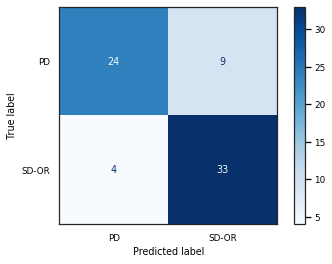

In [19]:
##confusion_matrix = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(classifier, X_test, y_test,
    display_labels=['PD', 'SD-OR'],
    cmap=plt.cm.Blues)


In [20]:
triple_neg_CM = confusion_matrix(y_test, X_test['KRAS_BRAF_NRAS_triple_neg_mut'])
FP = triple_neg_CM.sum(axis=0) - np.diag(triple_neg_CM)  
FN = triple_neg_CM.sum(axis=1) - np.diag(triple_neg_CM)
TP = np.diag(triple_neg_CM)
TN = triple_neg_CM.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
tripleNeg_TPR = TP/(TP+FN)
# Fall out or false positive rate
tripleNeg_FPR = FP/(FP+TN)


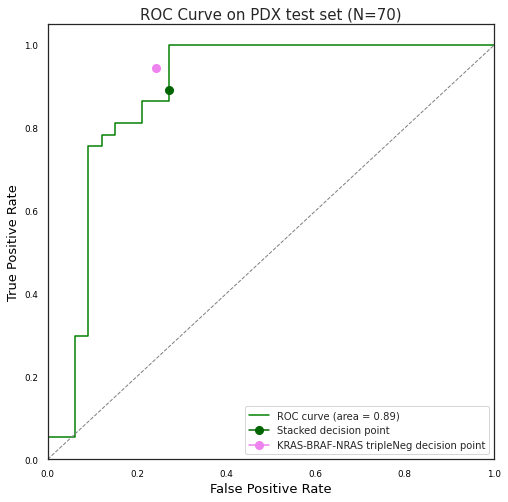

In [21]:
# return the marginal probability that the given sample has the label in question
y_pred = classifier.predict(X_test)
y_test_predict_proba = classifier.predict_proba(X_test)
fp_rates, tp_rates, _ = roc_curve(y_test,y_test_predict_proba[:,1])
roc_auc = auc(fp_rates, tp_rates)

fig, ax = plt.subplots(figsize=(8,8))
plt.plot(fp_rates, tp_rates, color='green',
            lw=1.5, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], lw=1, linestyle='--', color='grey')

#plot decision point:
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = [i for i in cm.ravel()]
plt.plot(fp/(fp+tn), 
	tp/(tp+fn), 
	marker='o',
	color='darkgreen', 
	markersize=8, 
	label='Stacked decision point')

# add triple negative baseline
#ax.axvline(tripleNeg_FPR[1], ls=':', c='k', 
#        label='KRAS-BRAF-NRAS tripleNeg median')
plt.plot(tripleNeg_FPR[1], 
	tripleNeg_TPR[1], 
	marker='o',
	c='violet', 
	markersize=8,
	zorder=10,
	label='KRAS-BRAF-NRAS tripleNeg decision point')
#ax.axhline(tripleNeg_TPR[1], ls=':', c='k', 
#        label='KRAS-BRAF-NRAS tripleNeg median')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', size=13)
plt.ylabel('True Positive Rate', size=13)
plt.title(f'ROC Curve on PDX test set (N={X_test.shape[0]})', size=15)
plt.legend(loc="lower right", prop={'size': 10})
plt.subplots_adjust(wspace=.3)


plt.savefig("bestStackedCVClassifier_vs_TripleNeg_AUC.pdf", 
                format='pdf', dpi=720, bbox_inches='tight')

In [22]:
# pickle best model from trials
model_filename = output.best_model
with open(model_filename, 'wb') as f:
    pickle.dump(best_model, f)


# Conclusions and Next Steps
Summarize findings here